In [22]:
"""pybullet_2"""

import math

import pybullet as p
import pybullet_data

import numpy as np

import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML, Video

from PIL import Image

In [14]:
class VirtualCamera:
    """Virtual camera class for capturing images from a specific viewpoint."""

    def __init__(self, position, target, fov=60, aspect=1, near=0.1, far=100):
        """Initialize the camera with position, target, and projection parameters.
        :param position: Camera position in world
        :type position: list
        :param target: Target position in world
        :type target: list
        :param fov: Field of view in degrees
        :type fov: float
        :param aspect: Aspect ratio of the camera
        :type aspect: float
        :param near: Near clipping plane distance
        :type near: float
        :param far: Far clipping plane distance
        :type far: float
        """
        self.position = position
        self.target = target
        self.fov = fov
        self.aspect = aspect
        self.near = near
        self.far = far

    def capture(self, width=640, height=480):
        """Capture an image from the camera.
        :param width: Width of the image
        :type width: int
        :param height: Height of the image
        :type height: int
        :return: Image data, including RGB and depth
        :rtype: tuple
        """
        view_matrix = p.computeViewMatrix(self.position, self.target, [0, 0, 1])
        proj_matrix = p.computeProjectionMatrixFOV(
            self.fov, self.aspect, self.near, self.far
        )
        return p.getCameraImage(
            width, height, viewMatrix=view_matrix, projectionMatrix=proj_matrix
        )


def add_cube(
    position: list[float],
    color_rgba: list[float] | None = None,
) -> int:
    """Add a cube to the simulation.

    :param position: Position of the cube in world coordinates
    :type position: list
    :param color_rgba: Color of the cube in RGBA format
    :type color_rgba: list
    :return: ID of the cube
    :rtype: int
    """
    if color_rgba is None:
        color_rgba = [1, 1, 1, 1]
    cube_id = p.loadURDF("cube.urdf", basePosition=position, globalScaling=0.09)
    p.changeVisualShape(cube_id, -1, rgbaColor=color_rgba)  # Change color to red
    return cube_id


def robot_home(robot_id, gripper_id):
    """Set the robot and gripper to their home positions."""
    joint_positions = [
        -0.000000,
        -0.000000,
        0.000000,
        1.570793,
        0.000000,
        -1.036725,
        0.000001,
    ]
    for joint_index in range(p.getNumJoints(robot_id)):
        p.resetJointState(robot_id, joint_index, joint_positions[joint_index])
        p.setJointMotorControl2(
            robot_id, joint_index, p.POSITION_CONTROL, joint_positions[joint_index], 0
        )

    joint_positions = [
        0.000000,
        -0.011130,
        -0.206421,
        0.205143,
        -0.009999,
        0.000000,
        -0.010055,
        0.000000,
    ]
    for joint_index in range(p.getNumJoints(gripper_id)):
        p.resetJointState(gripper_id, joint_index, joint_positions[joint_index])
        p.setJointMotorControl2(
            gripper_id,
            joint_index,
            p.POSITION_CONTROL,
            joint_positions[joint_index],
            0,
        )


def control_gripper(gripper_id, gripper_val):
    """Control the gripper to open or close."""
    p.setJointMotorControl2(
        gripper_id,
        4,
        p.POSITION_CONTROL,
        targetPosition=gripper_val * 0.05,
        force=100,
    )
    p.setJointMotorControl2(
        gripper_id,
        6,
        p.POSITION_CONTROL,
        targetPosition=gripper_val * 0.05,
        force=100,
    )


def go_to_target(
    robot_id,
    target_pos,
    target_orn=None,
    max_velocity=4.0,
    end_effector_index=6,
):
    """Move the robot to the target position."""
    if target_orn is None:
        target_orn = p.getQuaternionFromEuler([0, 1.01 * math.pi, 0])
    target_orn = p.getQuaternionFromEuler(target_orn)
    joint_poses = p.calculateInverseKinematics(
        robot_id, end_effector_index, target_pos, target_orn
    )
    for j in range(p.getNumJoints(robot_id)):
        p.setJointMotorControl2(
            bodyIndex=robot_id,
            jointIndex=j,
            controlMode=p.POSITION_CONTROL,
            targetPosition=joint_poses[j],
            maxVelocity=max_velocity,
        )


def load_robot_with_gripper():
    """Load the KUKA robot with a gripper attached."""
    robot_id = p.loadURDF(
        "kuka_iiwa/model_vr_limits.urdf",
        basePosition=[0.8, 0.200000, 0.0],
    )
    gripper_id = p.loadSDF("gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]

    _ = p.createConstraint(
        robot_id,
        6,
        gripper_id,
        0,
        p.JOINT_FIXED,
        [0, 0, 0],
        [0, 0, 0.05],
        [0, 0, 0],
    )
    kuka_cid2 = p.createConstraint(
        gripper_id,
        4,
        gripper_id,
        6,
        jointType=p.JOINT_GEAR,
        jointAxis=[1, 1, 1],
        parentFramePosition=[0, 0, 0],
        childFramePosition=[0, 0, 0],
    )
    p.changeConstraint(
        kuka_cid2,
        gearRatio=-1,
        erp=0.5,
        relativePositionTarget=0,
        maxForce=100,
    )

    p.resetBasePositionAndOrientation(
        gripper_id,
        [0.3425886946075733, 0.2000395928174248, 0.6830544683658055],
        [-0.000000, 0.964531, -0.000002, -0.263970],
    )

    robot_home(robot_id, gripper_id)

    return robot_id, gripper_id


def load_kuka_with_gripper():
    """Load xacro file"""
    robot_id = p.loadSDF(
        "kuka_iiwa/kuka_with_gripper.sdf",
    )
    return robot_id

In [19]:
client = p.connect(p.DIRECT)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Load plane and set gravity
p.loadURDF("plane.urdf")
p.setGravity(0, 0, -9.81)

p.loadURDF("tray/tray.urdf", [0.7, -0.3, 0.01])

robot_id, gripper_id = load_robot_with_gripper()
add_cube([0.2, 0.2, 0.01], [1, 0, 0, 1])
add_cube([0.0, 0.2, 0.01], [0, 1, 0, 1])
add_cube([0.2, 0.0, 0.01], [1, 0, 1, 1])
add_cube([0.0, 0.0, 0.01], [0, 0, 1, 1])


cam = VirtualCamera([0.6, -0.2, 1.5], [0.5, -0.5, 0.0])

In [ ]:
num_joints = p.getNumJoints(robot_id)
end_effector_index = 6

xyz_home = [0.3485885108719102, 0.19999583501695414, 0.6930555176178759]
rpy_home = [-3.141589497304125, -0.5340481159455732, -3.1415741612872514]

print("Number of joints:", num_joints)

Number of joints: 7


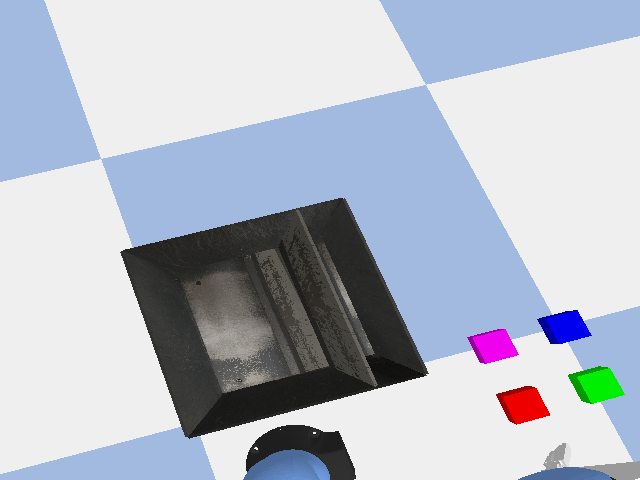

In [17]:
_, _, rgb, _, _ = cam.capture()
image = Image.fromarray(rgb)
image

In [ ]:
xyz_1 = [0.2, 0, 0.01]
rpy_1 = [math.pi, 0, math.pi]

xyz_2 = [0.8, -0.2, 0.01]
rpy_2 = [math.pi, 0, math.pi]

state = 0
target_pos = xyz_home.copy()
target_rpy = rpy_home.copy()
gripper_val = 0.0

z_offset_top = 0.5
z_offset_pick = 0.32

switch_step = 0

previous_distanse = 0.0
distance_1 = 0.0
count_stuck = 0
max_velocity = 4.0

vid = imageio_ffmpeg.write_frames("output.mp4", (640, 480), fps=30)
vid.send(None)  # seed the video writer with a blank frame

for step in range(1000):
    if step % 8 == 0:
        _, _, rgb, _, _ = cam.capture()
        vid.send(np.ascontiguousarray(rgb[:, :, :3]))

    link_state = p.getLinkState(robot_id, end_effector_index)
    end_effector_pos = link_state[0]
    end_effector_orn = p.getEulerFromQuaternion(link_state[1])

    previous_distanse = distance_1
    distance_1 = math.sqrt(
        (end_effector_pos[0] - target_pos[0]) ** 2
        + (end_effector_pos[1] - target_pos[1]) ** 2
        + (end_effector_pos[2] - target_pos[2]) ** 2
    )
    if distance_1 < 0.03:
        if (step - switch_step) > 20:
            switch_step = step
            state += 1

    if (previous_distanse - distance_1) < 0.0001:
        if distance_1 < 0.08:
            count_stuck += 1

    if count_stuck >= 10:
        count_stuck = 0
        switch_step = step
        state += 1

    print(f"step: {step}")
    print(f"\tEnd effector position: {end_effector_pos}")
    print(f"\tEnd effector orientation: {end_effector_orn}")
    print(f"\tstate: {state}")
    print(f"\tdistance: {distance_1}")

    if state == 0:
        target_pos = xyz_home.copy()
        target_rpy = rpy_home.copy()
        gripper_val = 0
    elif state == 1:
        # go on top of the target
        target_pos = xyz_1.copy()
        target_pos[2] += z_offset_top
        target_rpy = rpy_1.copy()
        gripper_val = 0
    elif state == 2:
        # go to ready to pick position
        target_pos = xyz_1.copy()
        target_pos[2] += z_offset_pick
        target_rpy = rpy_1.copy()
        gripper_val = 0
    elif state == 3:
        # go to ready to pick position
        target_pos = xyz_1.copy()
        target_pos[2] += z_offset_pick
        target_rpy = rpy_1.copy()
        gripper_val = 1
    elif state == 4:
        # go to the top of the target with gripper closed
        target_pos = xyz_1.copy()
        target_pos[2] += z_offset_top
        target_rpy = rpy_1.copy()
        gripper_val = 1
    elif state == 5:
        # go to the top of the destination with gripper closed
        target_pos = xyz_2.copy()
        target_pos[2] += z_offset_top
        target_rpy = rpy_2.copy()
        gripper_val = 1
        max_velocity = 2.0
    elif state == 6:
        # release the object
        target_pos = xyz_2.copy()
        target_pos[2] += z_offset_top
        target_rpy = rpy_2.copy()
        gripper_val = 0
    elif state == 7:
        # go to the home position
        target_pos = xyz_home.copy()
        target_rpy = rpy_home.copy()
        gripper_val = 0
    else:
        break

    go_to_target(
        robot_id,
        target_pos,
        target_rpy,
        max_velocity=max_velocity,
        end_effector_index=end_effector_index,
    )

    control_gripper(gripper_id, gripper_val)

    p.stepSimulation()


In [20]:
if client != -1:
    print("disconnected")
    p.disconnect(client)

disconnected


In [25]:
Video("output.mp4")